# Final exam code

The source code for resolving the exercises of the final exam for GRA4153 question 3

For this code, the following libraries are necessary:
- Pandas

The funcitons necessary for this notebook are found in the following modules

In [9]:
%load_ext autoreload
%autoreload 2
import DataImporter as get

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Q3.i
Selecting the correct sample for evaluating

In [10]:
indpro = get.Data("indpro.csv")
indpro.set_sample_range("1970-01-01", "2015-12-01")
indpro.sample.head(20)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

<Axes: title={'center': 'Time Series of INDPRO'}, xlabel='Date', ylabel='INDPRO'>

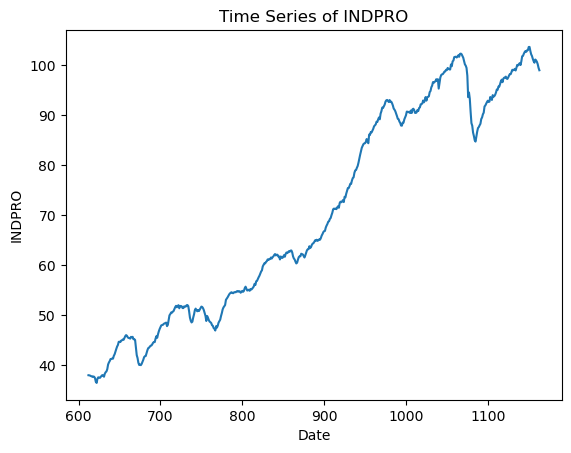

In [ ]:
indpro.sample["INDPRO"].plot(title='Time Series of INDPRO', ylabel='INDPRO', xlabel='Date')